In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from numpy.testing import assert_equal, assert_allclose
from figure_labeler import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, udf, when, avg
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F

from IPython.display import HTML
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
fl = FigureLabeler();
pd.options.mode.chained_assignment = None

<h1 style="text-align:center;">Evaluating Nathan's Potential as a Left Wing Player Using FIFA 2017 Data</h1>
<hr>

<a name="top"></a>
#### Table of Contents:

[ref0]: #exec_summary
- [Executive Summary][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref2]: #motiv
- [Motivation][ref2]

[ref3]: #dat_sor
- [Data Source][ref3]

[ref4]: #dat_prep
- [Data Preprocessing][ref4]

[ref5]: #dat_expl
- [Data Exploration][ref5]

[ref6]: #res_dis
- [Results and Discussions][ref6]

[ref7]: #conc
- [Conclusion and Recommendations][ref7]

[ref8]: #refe
- [References][ref8]

***

<a name="exec_summary"></a>
## Executive Summary
In this section, provide a concise overview of the project, highlighting the key findings and insights derived from the FIFA 2017 dataset analysis.
***

Nathan, a promising football rookie, is exploring career opportunities with top football clubs. To aid in his decision-making process, his manager has leveraged statistical analysis using the Complete FIFA 2017 Player dataset, focusing on players in Nathan's preferred position, Left Wing (LW). The analysis reveals the distribution of LW players across clubs, average ratings of LW players, and the typical attributes associated with this position. Visualizations highlight key insights, including the top clubs with the highest number of LW players, the highest-rated LW players, and average attribute levels such as Ball Control, Dribbling, and Speed. Additionally, a comparative analysis was conducted between Nathan's stats and those of the top 10 LW players in each attribute, showcased through a radar chart. This comprehensive analysis provides a clear understanding of where Nathan might fit best and how his skills align with the current standards in his position.

[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
## Problem Statement
In this section, we address the challenge of analyzing player performance data to identify key attributes that contribute to a player's overall rating and position effectiveness.
***

By utilizing the Complete FIFA 2017 Player dataset, the analysis focuses on players in Nathan's preferred position, Left Wing (LW). The goal is to evaluate where Nathan might best fit among top football clubs and identify areas for his development. The analysis involves exploring the distribution of LW players across clubs, identifying top LW players by average rating, and analyzing key attributes such as ball control, dribbling, and speed. Visualizations include bar plots for player distribution and attribute comparisons, as well as radar charts to compare Nathan's stats with those of the top LW players. This comprehensive approach aims to provide actionable insights into Nathan's potential fit within the football landscape and his prospects for growth.

[ref]: #top
[Back to Table of Contents][ref]

<a name="motiv"></a>
## Motivation
In this section, the group wanted to address the potential merits of incorporating data analytics into standard football evaluation.
***

The motivation stems from the increasing reliance on data-driven decision-making in sports management. By harnessing the power of data analytics, football clubs can gain a competitive edge in player recruitment, tactical planning, and overall performance improvement. The motivation is to explore how data analytics can enhance traditional scouting methods by providing objective measurements of player skills, thereby optimizing team compositions and maximizing on-field performance.

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_sor"></a>
## Data Source
In this section, the data source of the study is indicated.
***

The analysis adopts a systematic approach by obtaining the "Complete FIFA 2017 Player dataset (Global)" from Kaggle, authored by Soumitra Agarwal.

*Click this for the dataset:* [Dataset Link](https://www.kaggle.com/datasets/artimous/complete-fifa-2017-player-dataset-global/data)

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_prep"></a>
## Data Preprocessing
***

In this section, the dataset is loaded into a PySpark DataFrame and initial data cleaning steps are performed to ensure data quality and completeness.

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .getOrCreate()
)

In [4]:
fifa_spark_df = spark.read.csv(
    'FullData.csv',
    sep=',', header=True, inferSchema=True
)

In [5]:
fl.table_caption("FIFA Data Overview",
                 "This table presents the first five records from the FIFA dataset, showcasing key attributes such as player names, positions, and ratings.")

fifa_spark_df.limit(5).show()

+-----------------+-----------+-----------------+------------+------------+-------------+--------+------------+---------------+------+------+------+--------------+----------+---+------------------+---------------+---------+-----------+------------+---------+-------+--------------+---------------+----------+---------+------------------+-------------+------+---------+--------+----------+---------+------------+-----+-------+--------+-------+-------+-------+-------+----------+---------+----------+-----+-----------------+---------+-------+--------------+---------+----------+-----------+-----------+
|             Name|Nationality|National_Position|National_Kit|        Club|Club_Position|Club_Kit|Club_Joining|Contract_Expiry|Rating|Height|Weight|Preffered_Foot|Birth_Date|Age|Preffered_Position|      Work_Rate|Weak_foot|Skill_Moves|Ball_Control|Dribbling|Marking|Sliding_Tackle|Standing_Tackle|Aggression|Reactions|Attacking_Position|Interceptions|Vision|Composure|Crossing|Short_Pass|Long_Pass|A

In [6]:
for column in fifa_spark_df.columns:
    null_count = fifa_spark_df.filter(col(column).isNull()).count()
    print(f"{column}: {null_count}")

Name: 0
Nationality: 0
National_Position: 16513
National_Kit: 16513
Club: 0
Club_Position: 1
Club_Kit: 1
Club_Joining: 1
Contract_Expiry: 1
Rating: 0
Height: 0
Weight: 0
Preffered_Foot: 0
Birth_Date: 0
Age: 0
Preffered_Position: 0
Work_Rate: 0
Weak_foot: 0
Skill_Moves: 0
Ball_Control: 0
Dribbling: 0
Marking: 0
Sliding_Tackle: 0
Standing_Tackle: 0
Aggression: 0
Reactions: 0
Attacking_Position: 0
Interceptions: 0
Vision: 0
Composure: 0
Crossing: 0
Short_Pass: 0
Long_Pass: 0
Acceleration: 0
Speed: 0
Stamina: 0
Strength: 0
Balance: 0
Agility: 0
Jumping: 0
Heading: 0
Shot_Power: 0
Finishing: 0
Long_Shots: 0
Curve: 0
Freekick_Accuracy: 0
Penalties: 0
Volleys: 0
GK_Positioning: 0
GK_Diving: 0
GK_Kicking: 0
GK_Handling: 0
GK_Reflexes: 0


In [7]:
fifa_spark_df_clean = fifa_spark_df.na.drop()
print(fifa_spark_df_clean.count())

1075


In [8]:
fifa_spark_df.columns

['Name',
 'Nationality',
 'National_Position',
 'National_Kit',
 'Club',
 'Club_Position',
 'Club_Kit',
 'Club_Joining',
 'Contract_Expiry',
 'Rating',
 'Height',
 'Weight',
 'Preffered_Foot',
 'Birth_Date',
 'Age',
 'Preffered_Position',
 'Work_Rate',
 'Weak_foot',
 'Skill_Moves',
 'Ball_Control',
 'Dribbling',
 'Marking',
 'Sliding_Tackle',
 'Standing_Tackle',
 'Aggression',
 'Reactions',
 'Attacking_Position',
 'Interceptions',
 'Vision',
 'Composure',
 'Crossing',
 'Short_Pass',
 'Long_Pass',
 'Acceleration',
 'Speed',
 'Stamina',
 'Strength',
 'Balance',
 'Agility',
 'Jumping',
 'Heading',
 'Shot_Power',
 'Finishing',
 'Long_Shots',
 'Curve',
 'Freekick_Accuracy',
 'Penalties',
 'Volleys',
 'GK_Positioning',
 'GK_Diving',
 'GK_Kicking',
 'GK_Handling',
 'GK_Reflexes']

In [9]:
fl.table_caption("Descriptive Statistics of Cleaned FIFA Dataset",
                 "This table summarizes key statistical metrics for the cleaned FIFA dataset and it provides an overview of the data's distribution and variability.")

fifa_spark_df_clean.describe().show(5)

+-------+----------------+-----------+-----------------+-----------------+----------+-------------+------------------+------------+------------------+-----------------+------+------+--------------+----------+------------------+------------------+---------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            Name|Nationality|National_Position|     Na

In [10]:
fl.table_caption("Left Wing Players from Cleaned FIFA Dataset",
                 "This table displays the first five records of players who occupy the Left Wing (LW) position in the cleaned FIFA dataset.")

lw_players_df = fifa_spark_df_clean.filter(fifa_spark_df_clean.Club_Position == 'LW')
lw_players_df.show(5)

+-----------------+-----------+-----------------+------------+---------------+-------------+--------+------------+---------------+------+------+------+--------------+----------+---+------------------+-------------+---------+-----------+------------+---------+-------+--------------+---------------+----------+---------+------------------+-------------+------+---------+--------+----------+---------+------------+-----+-------+--------+-------+-------+-------+-------+----------+---------+----------+-----+-----------------+---------+-------+--------------+---------+----------+-----------+-----------+
|             Name|Nationality|National_Position|National_Kit|           Club|Club_Position|Club_Kit|Club_Joining|Contract_Expiry|Rating|Height|Weight|Preffered_Foot|Birth_Date|Age|Preffered_Position|    Work_Rate|Weak_foot|Skill_Moves|Ball_Control|Dribbling|Marking|Sliding_Tackle|Standing_Tackle|Aggression|Reactions|Attacking_Position|Interceptions|Vision|Composure|Crossing|Short_Pass|Long_Pass

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_expl"></a>
## Data Exploration
***

In this section, explore the dataset to uncover insights and patterns related to player attributes and performance.

In [11]:
fl.table_caption("Number of Left Wing Players by Club",
                 "This table shows the count of Left Wing (LW) players for each club and it provides insights into which clubs have the highest representation of LW players.")

club_count_df = (
    lw_players_df.groupBy('Club')
    .count()
    .orderBy('count', 
             ascending=False)
)
club_count_df.show()

+---------------+-----+
|           Club|count|
+---------------+-----+
|  SC Heerenveen|    1|
|            PSG|    1|
|        Bologna|    1|
|    Real Madrid|    1|
|Manchester City|    1|
|      Cruz Azul|    1|
|          Milan|    1|
|   FC Barcelona|    1|
|    Valencia CF|    1|
|         Napoli|    1|
| Olym. Lyonnais|    1|
|Olym. Marseille|    1|
|      Liverpool|    1|
|     Angers SCO|    1|
|        Tondela|    1|
|        Chelsea|    1|
+---------------+-----+



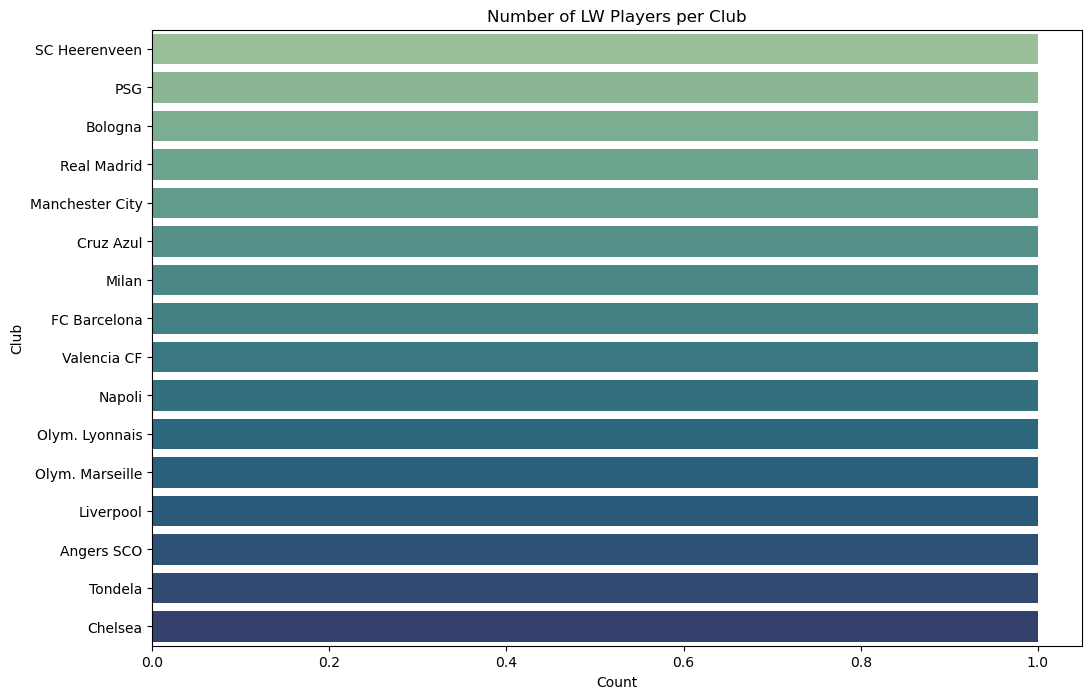

In [12]:
club_count_pd = club_count_df.toPandas()

plt.figure(figsize=(12, 8))
sns.countplot(y='Club', 
              data=club_count_pd, 
              palette="crest")
plt.title('Number of LW Players per Club')
plt.xlabel('Count')
plt.ylabel('Club')
plt.show()

fl.fig_caption("Number of Left Wing Players per Club",
               "The illustration of Left Wing (LW) players across different clubs.")

The graph shows the count of left wing players per club. The x-axis represents the count and the y-axis represents the name of the club. The horizontal bars represent the number of LW players at each club, with clubs having more LW players shown at the top. The graph correlates to table number 4, where it also shows the number of left wing players by club. 

In [13]:
fl.table_caption("Average Rating of Left Wing Players",
                 "This table presents the average rating for each Left Wing (LW) player and it highlights the players with the highest average ratings in the LW position.")

avg_rating_df = (
    lw_players_df.groupBy('Name')
    .agg(avg('Rating')
         .alias('Average_Rating'))
    .orderBy('Average_Rating', 
             ascending=False)
)
avg_rating_df.show()

+-----------------+--------------+
|             Name|Average_Rating|
+-----------------+--------------+
|Cristiano Ronaldo|          94.0|
|           Neymar|          92.0|
|      Eden Hazard|          89.0|
|         Coutinho|          86.0|
|    Dimitri Payet|          85.0|
|  Lorenzo Insigne|          84.0|
|   Julian Draxler|          83.0|
|             Nani|          83.0|
|         Deulofeu|          81.0|
|       Leroy Sané|          80.0|
|    Memphis Depay|          79.0|
|      Sam Larsson|          77.0|
|  Ladislav Krejčí|          77.0|
| Karl Toko-Ekambi|          74.0|
|     Jhon Murillo|          72.0|
| Martín Rodríguez|          72.0|
+-----------------+--------------+



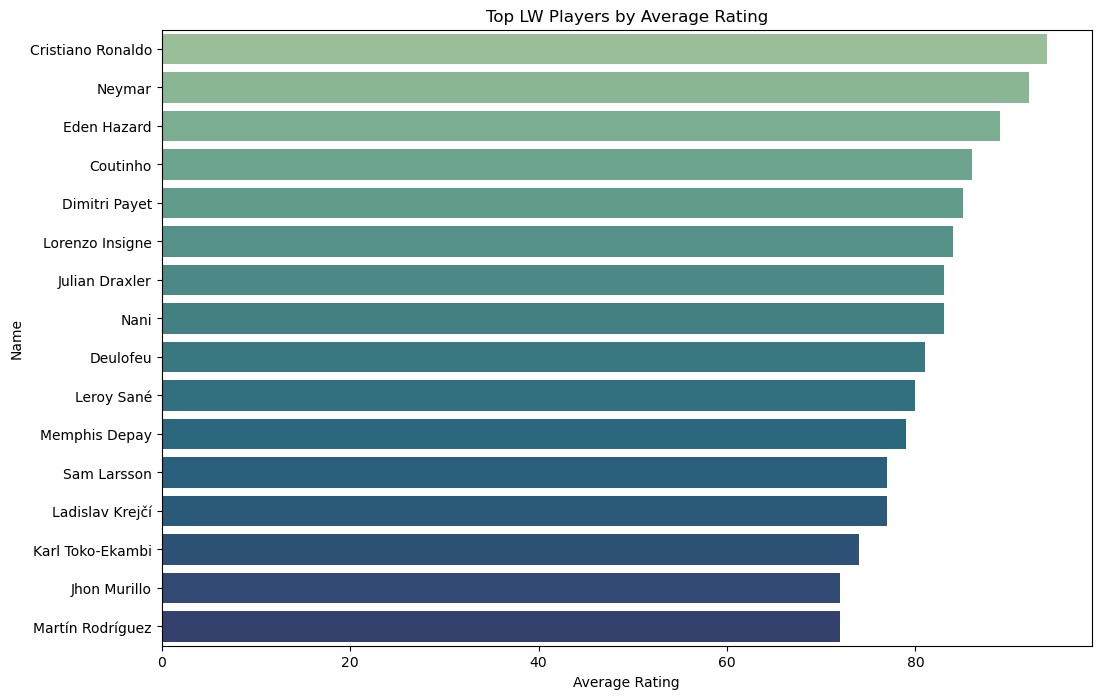

In [14]:
avg_rating_pd = avg_rating_df.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average_Rating', y='Name', data=avg_rating_pd, palette="crest")
plt.title('Top LW Players by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Name')
plt.show()

fl.fig_caption("Top Left Wing Players by Average Rating",
               "This bar plot displays the average ratings of the top Left Wing (LW) players. Players are ranked by their average rating, with the highest-rated players shown at the top. The plot provides a clear view of the top performers in the LW position.")

The graph shows the average rating of the top 10 LW players. The x-axis shows the average rating from 0 to more than 80 count of average and the y-axis shows the name of the top ten left wing players with the highest average rating. As seen in the graph, Cristiano Ronaldo has the highest average rating with more than 80 average rating and Sam Larsson has the lowest average rating. The rank of Ronaldo being the top average ranking in LW demonstrates his control and good performance as a left wing player. 

In [15]:
fl.table_caption("Average Attributes for Left Wing Players",
                 "This table shows the average values for various attributes of Left Wing (LW) players, including Ball Control, Dribbling, and Speed.")

lw_attributes_df = lw_players_df.select(
    avg('Ball_Control').alias('Avg_Ball_Control'),
    avg('Dribbling').alias('Avg_Dribbling'),
    avg('Crossing').alias('Avg_Crossing'),
    avg('Short_Pass').alias('Avg_Short_Pass'),
    avg('Speed').alias('Avg_Speed'),
    avg('Acceleration').alias('Avg_Acceleration'),
    avg('Stamina').alias('Avg_Stamina'),
    avg('Agility').alias('Avg_Agility'),
    avg('Finishing').alias('Avg_Finishing'),
    avg('Vision').alias('Avg_Vision')
)

lw_attributes_df.show()

+----------------+-------------+------------+--------------+---------+----------------+-----------+-----------+-------------+----------+
|Avg_Ball_Control|Avg_Dribbling|Avg_Crossing|Avg_Short_Pass|Avg_Speed|Avg_Acceleration|Avg_Stamina|Avg_Agility|Avg_Finishing|Avg_Vision|
+----------------+-------------+------------+--------------+---------+----------------+-----------+-----------+-------------+----------+
|         83.8125|        85.75|     73.4375|        76.375|   84.625|         87.1875|     76.125|    87.4375|       75.625|   75.3125|
+----------------+-------------+------------+--------------+---------+----------------+-----------+-----------+-------------+----------+



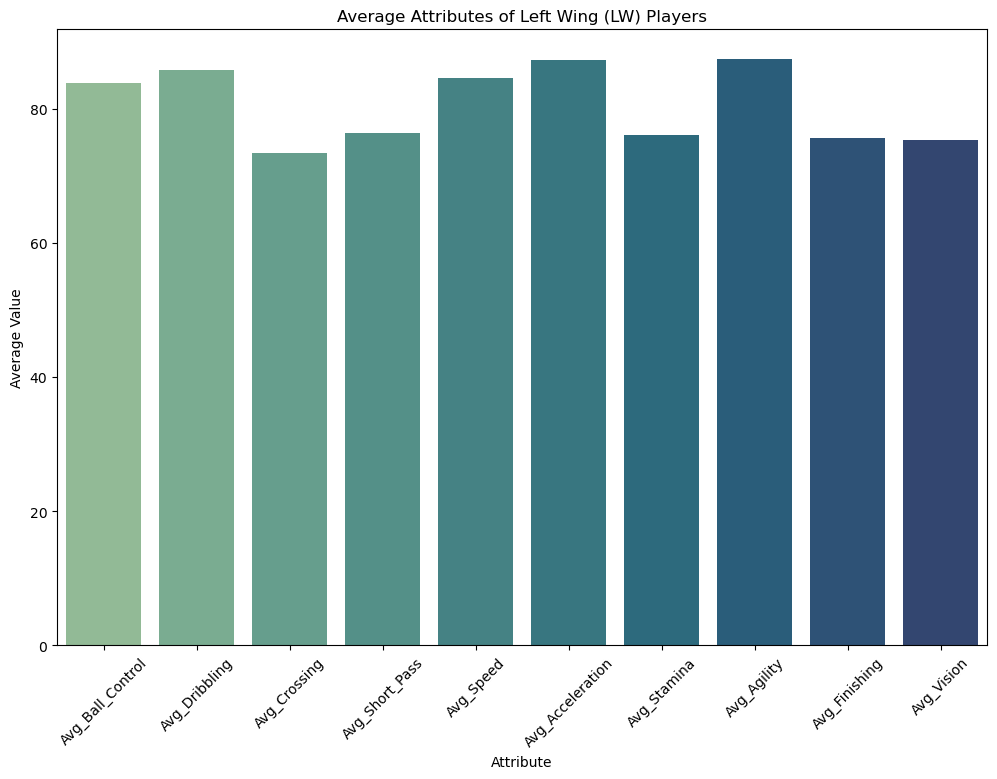

In [16]:
lw_attributes_pd = lw_attributes_df.toPandas()

attributes = ['Avg_Ball_Control', 
              'Avg_Dribbling', 
              'Avg_Crossing', 
              'Avg_Short_Pass', 
              'Avg_Speed', 
              'Avg_Acceleration', 
              'Avg_Stamina', 
              'Avg_Agility', 
              'Avg_Finishing', 
              'Avg_Vision']
values = [lw_attributes_pd[attr].values[0] for attr in attributes]

plt.figure(figsize=(12, 8))
sns.barplot(x=attributes, y=values, palette="crest")
plt.xticks(rotation=45)
plt.title('Average Attributes of Left Wing (LW) Players')
plt.xlabel('Attribute')
plt.ylabel('Average Value')
plt.show()

fl.fig_caption("Average Attributes of Left Wing (LW) Players",
               "This bar plot illustrates the average values of key attributes for Left Wing (LW) players. The plot provides a comparative view of attributes such as Ball Control, Dribbling, and Speed, highlighting the overall performance metrics for LW players.")

The graph shows the average attributes of left wing players. The x-axis shows the lists of various different attributes and the y-axis shows the measured scale of each of the attributes. As seen in the graph, the attributes, average ball control, average dibriling, average speed, average acceleration, and average agility has the highest average attributes of left wing players with above 80 average value. This observation means that the left wing players have the highest average attributes in the mentioned attributes. 

In [17]:
attributes = ["Ball_Control", 
              "Dribbling", 
              "Crossing", 
              "Short_Pass", 
              "Speed", 
              "Acceleration", 
              "Stamina", 
              "Agility", 
              "Finishing", 
              "Vision"]

top_10_dfs = {}

In [18]:
fl.table_caption("Top 10 Left Wing Players by Attribute",
                 "This table displays the top 10 Left Wing (LW) players for each specified attribute, such as Ball Control and Speed. Each table highlights the leading players for the given attribute, showcasing their top performances.")

for attribute in attributes:
    df = lw_players_df.select("Name", attribute).orderBy(col(attribute).desc()).limit(10)
    top_10_dfs[attribute] = df.toPandas()
    print(f"Top 10 players by {attribute.replace('_', ' ').title()}:")
    df.show()
    print("\n")

Top 10 players by Ball Control:
+-----------------+------------+
|             Name|Ball_Control|
+-----------------+------------+
|           Neymar|          95|
|Cristiano Ronaldo|          93|
|      Eden Hazard|          91|
|    Dimitri Payet|          90|
|  Lorenzo Insigne|          90|
|         Coutinho|          88|
|             Nani|          86|
|         Deulofeu|          86|
|   Julian Draxler|          85|
|       Leroy Sané|          83|
+-----------------+------------+



Top 10 players by Dribbling:
+-----------------+---------+
|             Name|Dribbling|
+-----------------+---------+
|           Neymar|       96|
|      Eden Hazard|       93|
|Cristiano Ronaldo|       92|
|    Dimitri Payet|       89|
|         Deulofeu|       89|
|         Coutinho|       88|
|  Lorenzo Insigne|       88|
|   Julian Draxler|       87|
|             Nani|       87|
|       Leroy Sané|       86|
+-----------------+---------+



Top 10 players by Crossing:
+-----------------+----

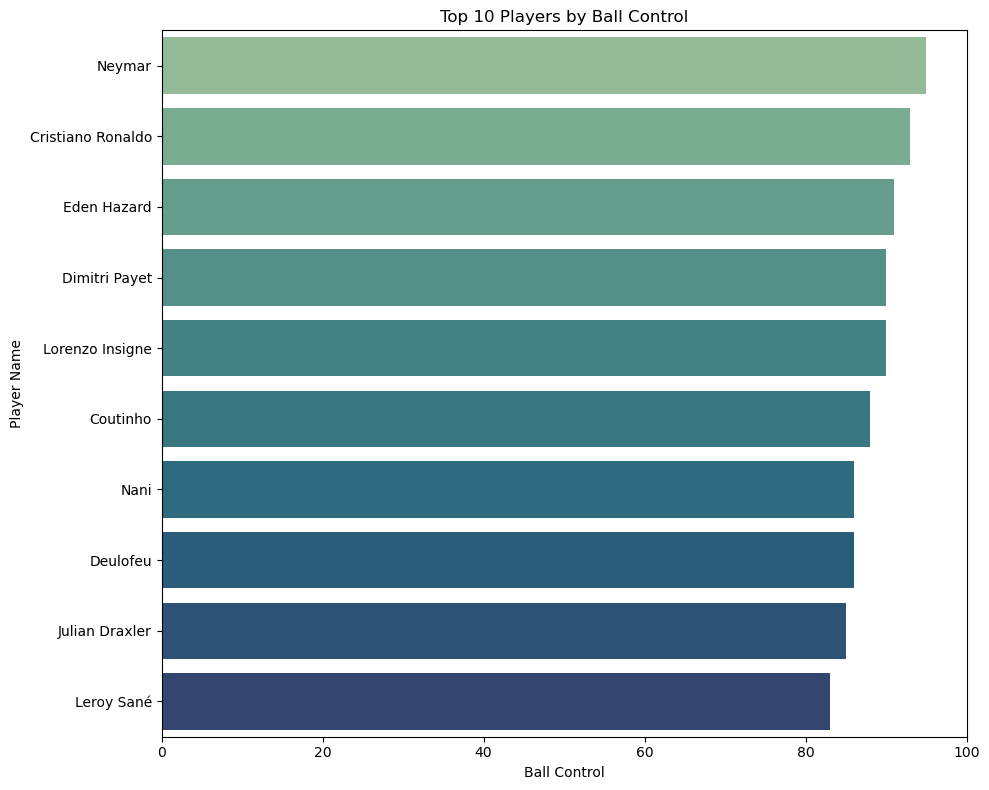

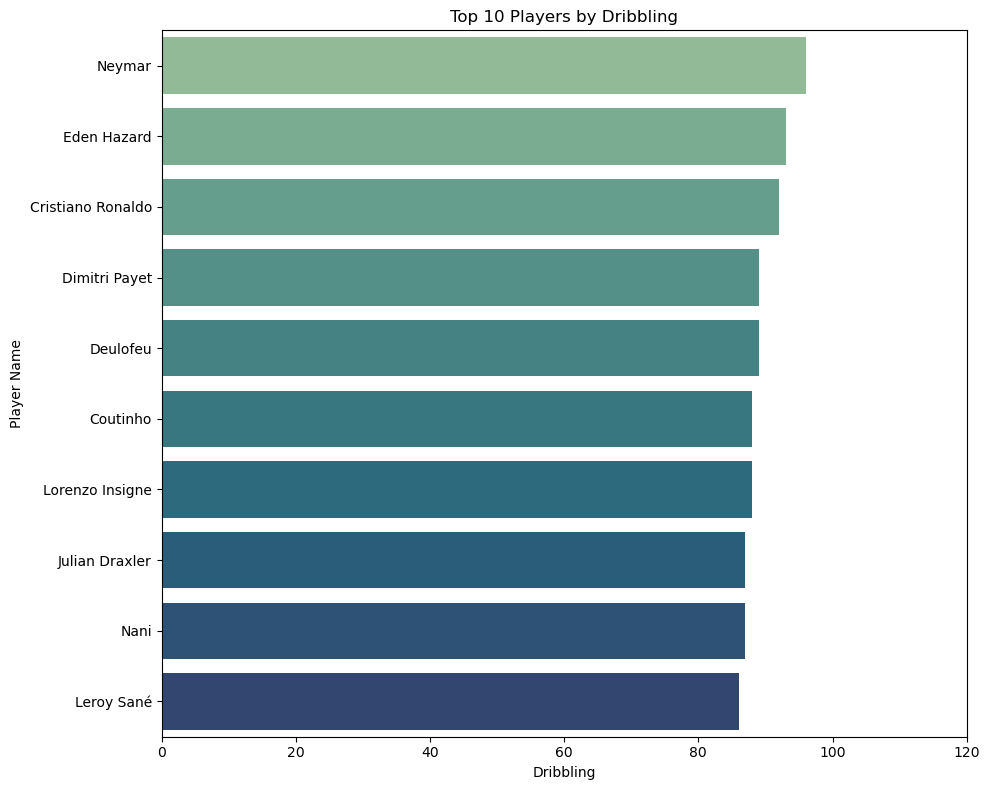

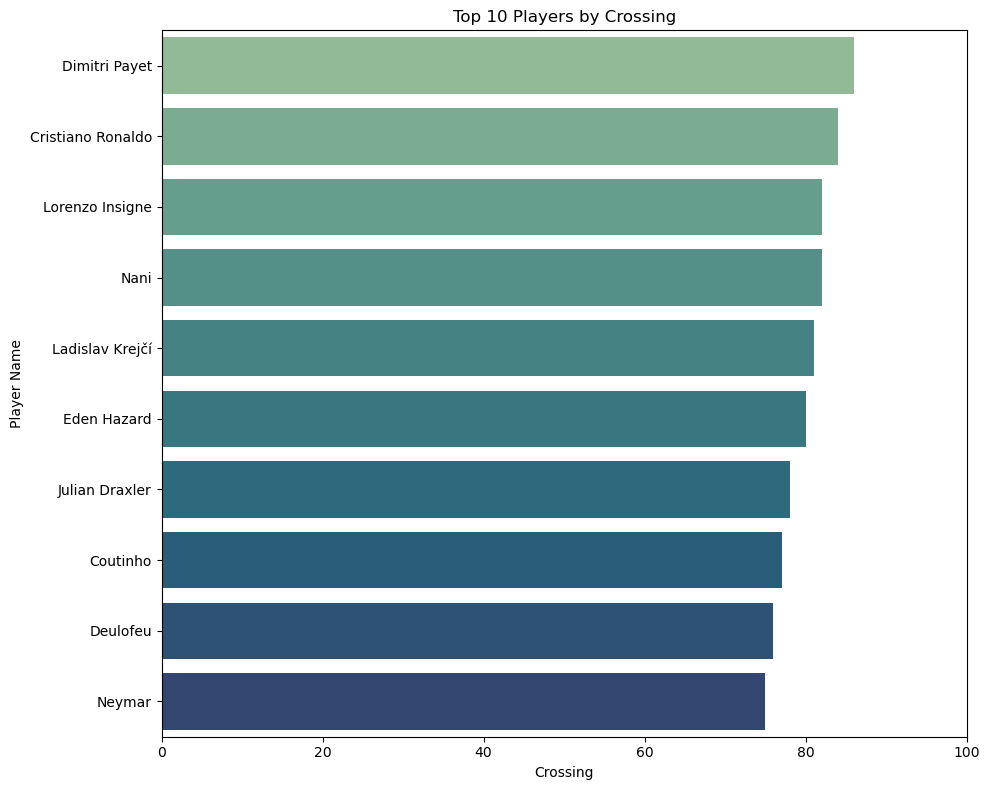

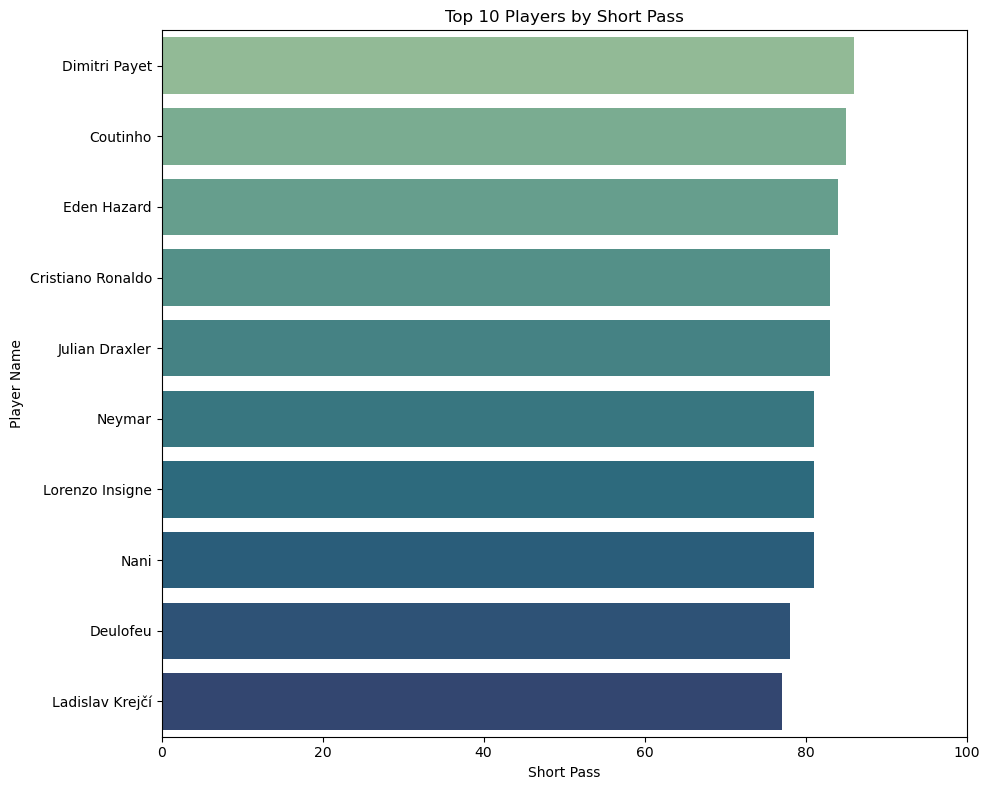

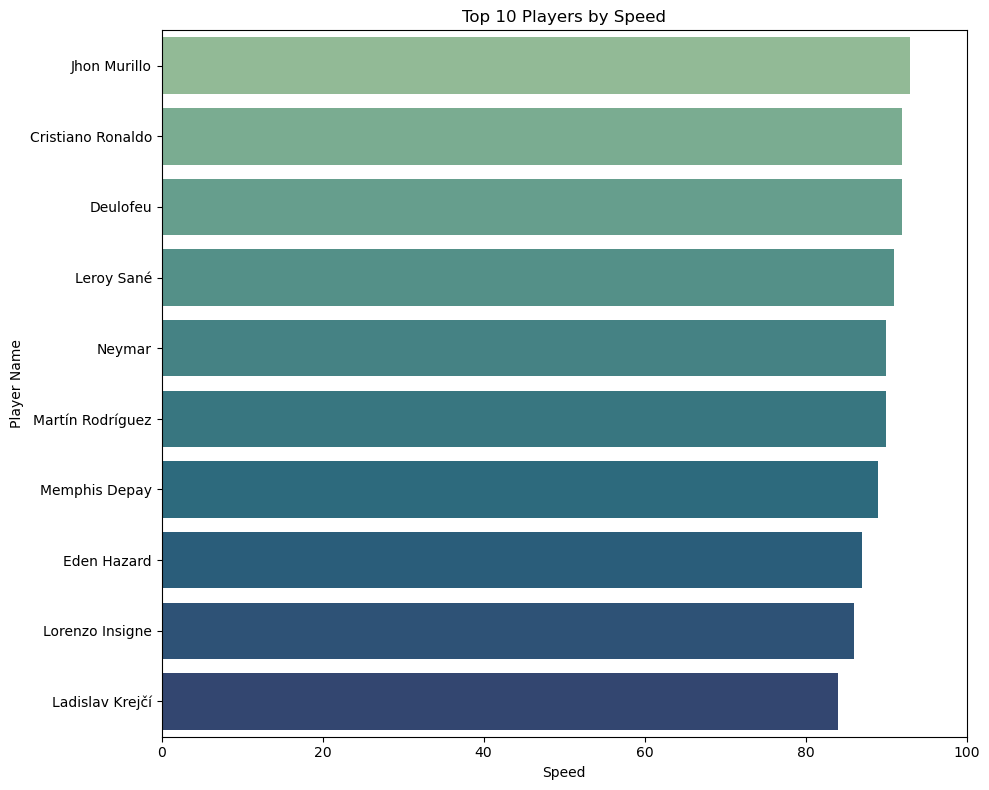

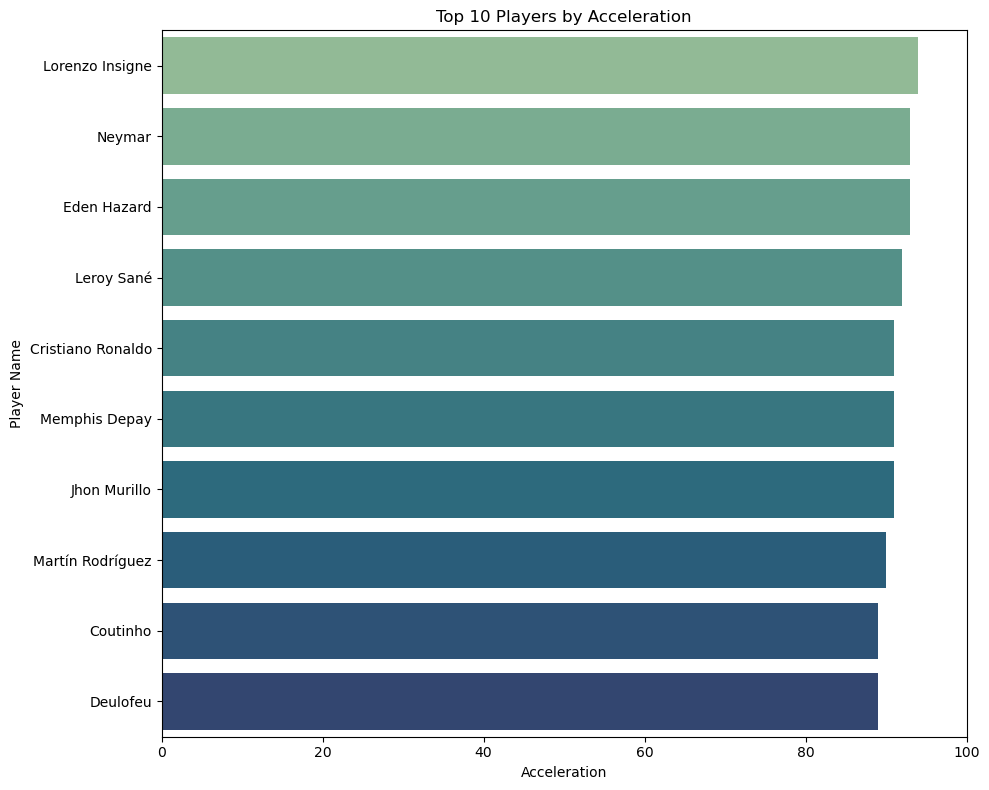

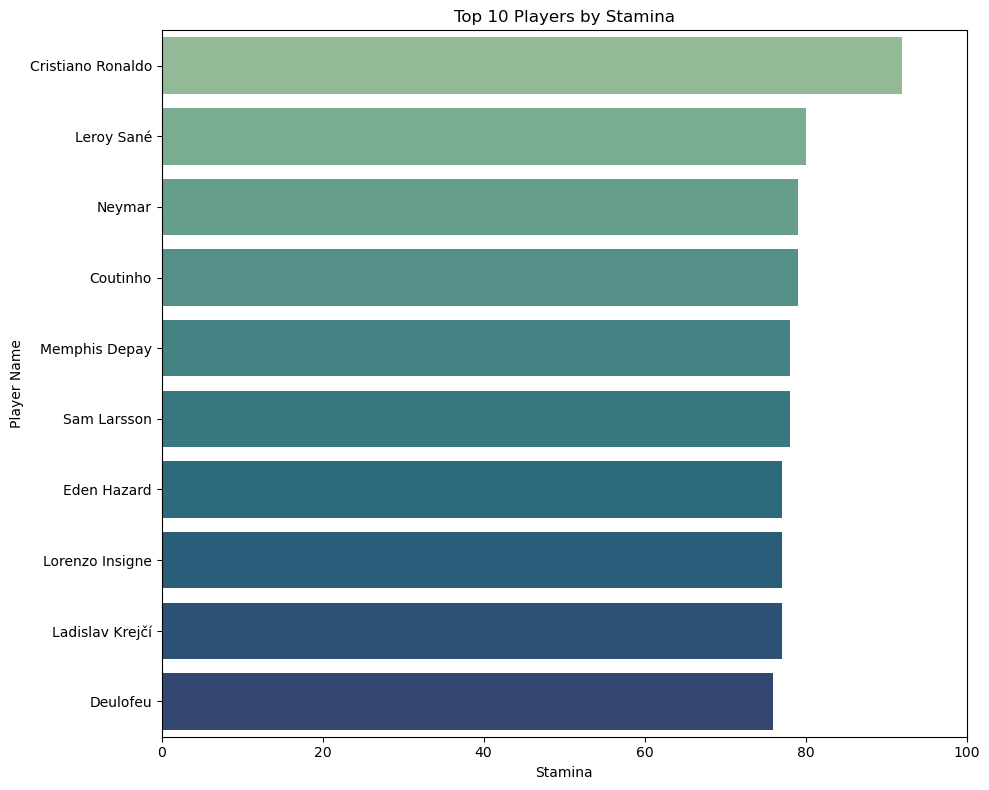

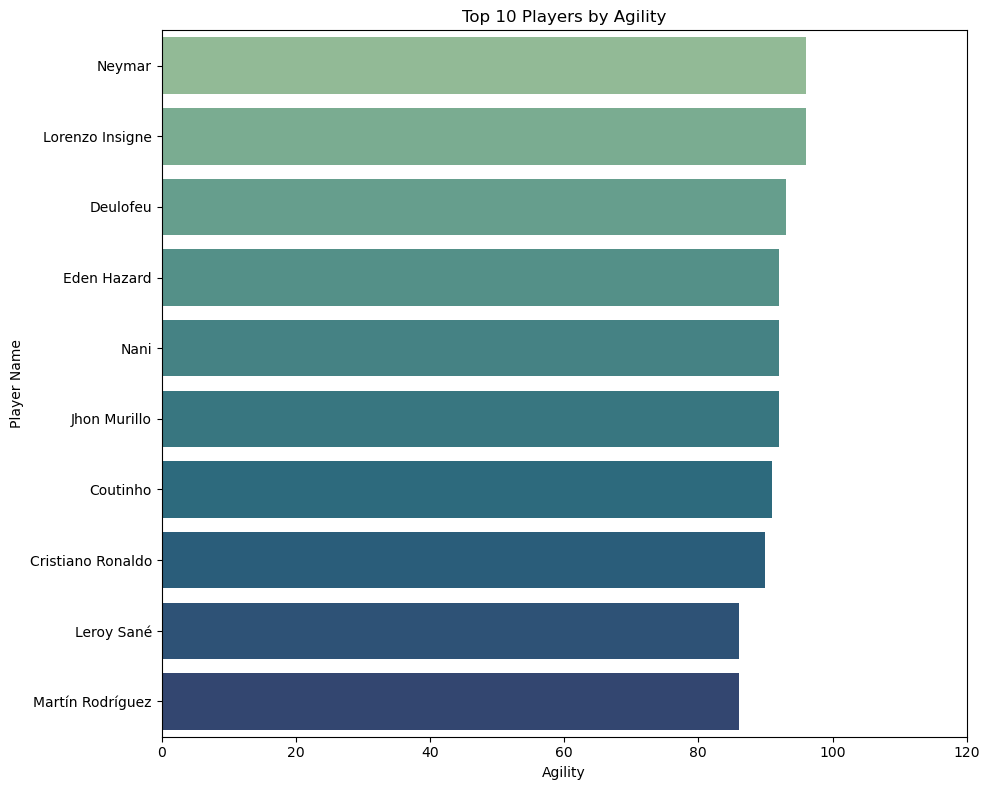

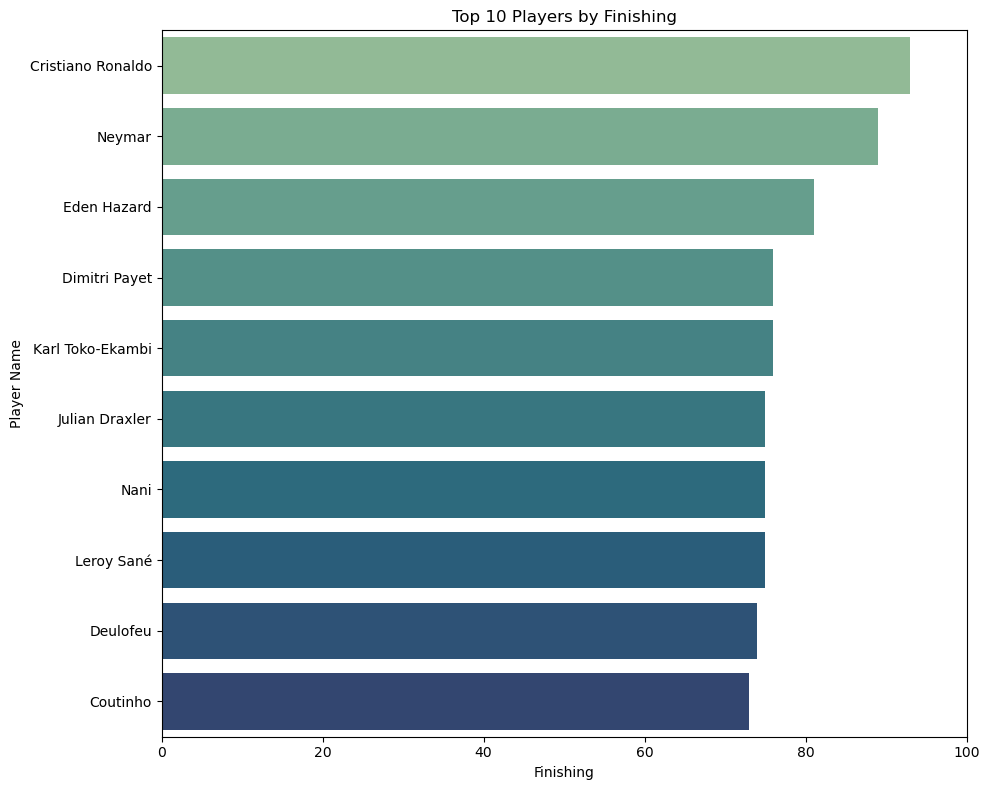

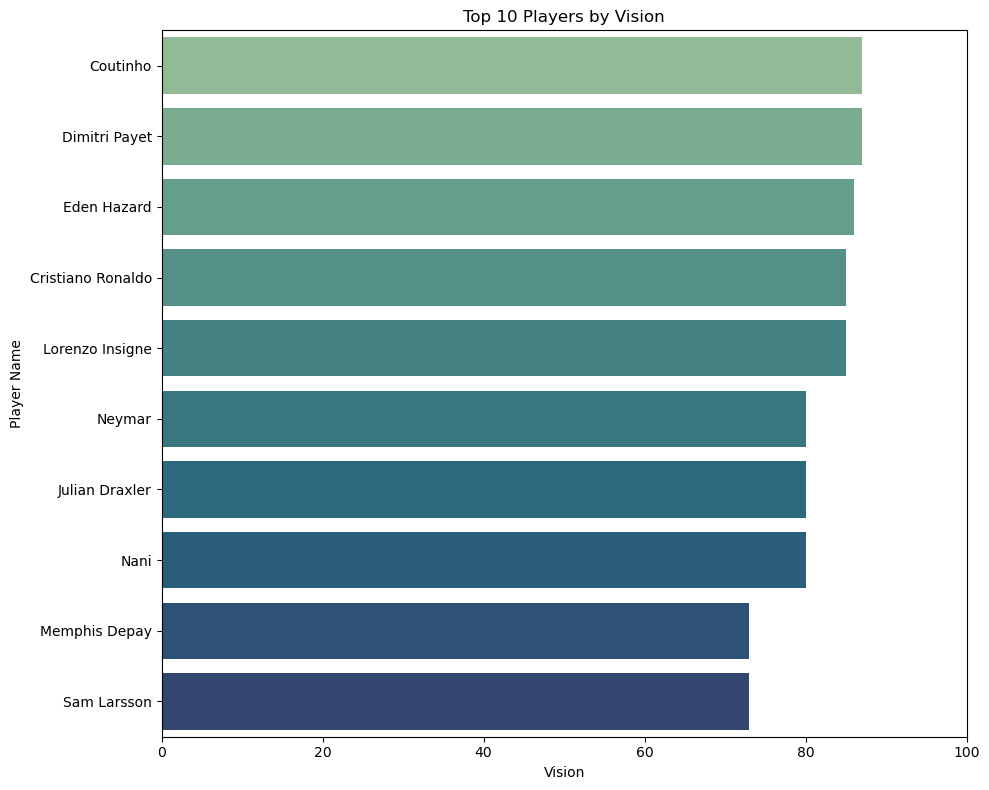

In [19]:
for attribute, df_pd in top_10_dfs.items():
    if not pd.api.types.is_numeric_dtype(df_pd[attribute]):
        df_pd[attribute] = pd.to_numeric(df_pd[attribute], errors='coerce')

    fig, ax = plt.subplots(figsize=(10, 8))

    sns.barplot(x=attribute, y='Name', data=df_pd, palette="crest", ax=ax)
    ax.set_title(f'Top 10 Players by {attribute.replace("_", " ").title()}')
    ax.set_xlabel(attribute.replace("_", " ").title())
    ax.set_ylabel('Player Name')
    ax.set_xticks(ax.get_xticks()) 

    plt.tight_layout()
    plt.show()
    
fl.fig_caption("Top 10 Players by Each Attribute",
               "These bar plots display the top 10 Left Wing (LW) players for each attribute, including metrics such as Ball Control and Speed. Each plot highlights the leading players for the specified attribute, showcasing their top performances in a clear, comparative format.")

In the previous bar graph, it shows the average attributes of left wing players. Now, this ten graph evaluates the top ten players per attribute; specifically, ball control, dribbling, crossing, short pass, speed, acceleration, stamina, agility, finishing, vision. The first graph shows the top ten players by **ball control**. It can be seen that the highest player to have ball control with over 90 is Neymar and Cristiano Ronaldo. Meanwhile the lowest are Julian Draxier and Leroy Sane with above 80 but less than 90. The value of the highest and lowest players by ball control does not have a huge difference but can dispense a significant difference. 

The second bar graph illustrates the top ten players by dribbling. The highest players in **dribbling** are Neymar and Eden Hazard with almost a hundred count. The lowest players are Nani and Leroy Sane with over 80 but less than 90. It can be seen that player Neymar remained number one as the highest player in both ball control and dribbling. The following bar graph is the top ten players by **crossing**. The top players in crossing are Dimitri Payet and Cristiano Ronaldo with over 80 and the lowest players are Deulofeu and Neymer with over 60 but less than 80. It can be associated that there is a significant difference in the highest and lowest players in crossing and that player Neymar can be observed to have a huge change in ranking.

Succeeding to that is the bar graph of **short pass** with its highest players Dimitri Payet and Coutinho with over 80 but less than 90 and the lowest players are Deulofeu and Ladislav with a near of 80. The following bar graph is **speed** with its highest player Jhon Murillo and Cristiano Ronaldo with 90 and the lowest players are Lorenzo Insigne and Ladislav with over 80 but less than 90. The difference of the highest and lowest players in both short pass and speed do not have a huge discrepancy than the previous graphs. 

The next bar graph is the **acceleration**. The highest players are Lorenzo Insigne and Neymar with over 90 and the lowest players are Coutinho and Deulofeu with over 80 but less than 90. It can be observed that Neymar can be seen in the highest players again in the top ten players of acceleration. Following that is the bar graph of **stamina**, the highest player is Cristiano Ronaldo with over 90 but less than a hundred and the lowest player is Deulofeu with less than 80. It is highly evident that the difference between the highest and lowest player has a huge difference and can be interpreted that among the top ten players, Ronaldo has the best stamina. Proceeding is the **Agility** bar graph where Neymar and Lorenzo Insigne have the highest measure agility with over 90 but less than 100 and the lowest players are Leroy Sane and Martin Rodriguez with over 80 but less than 90. 

Consequently, the top ten bar graph of **finishing** has the highest players with over 90 but less than 100, namely, Cristiano Ronalado and Neymar. While the lowest players are Deulofeu and Countinho with over 70 but less than 80. There is a huge difference in the highest and lowest players by finishing that can imply that Ronaldo has the best finishing among the top ten players of the said attribute. Lastly, the bar graph of **vision**, with its highest players, Countinho and Dimitri Payet with over 80 but less than 90 and the lowest players are Memphis Depay and Sam Larsson with over 70 but less than 80. The difference of the highest and lowest players is not as massive as the finishing evaluation bar graph but can deliberate a significant observation. Overall, the ten bar graphs can indicate that there are similar or common players' names on the list that can be associated that there are also accelerating in the different attributes. 

In [20]:
nathan_stats = {
    'Ball_Control': 85,
    'Dribbling': 88,
    'Crossing': 80,
    'Short_Pass': 75,
    'Speed': 90,
    'Acceleration': 92,
    'Stamina': 85,
    'Agility': 89,
    'Finishing': 78,
    'Vision': 82
}

max_values = {attr: top_10_dfs[attr][attr].max() for attr in attributes}
comparison_df = pd.DataFrame({
    'Attribute': list(nathan_stats.keys()) + list(max_values.keys()),
    'Value': list(nathan_stats.values()) + list(max_values.values()),
    'Type': ['Nathan']*len(nathan_stats) + ['Top']*len(max_values)
})

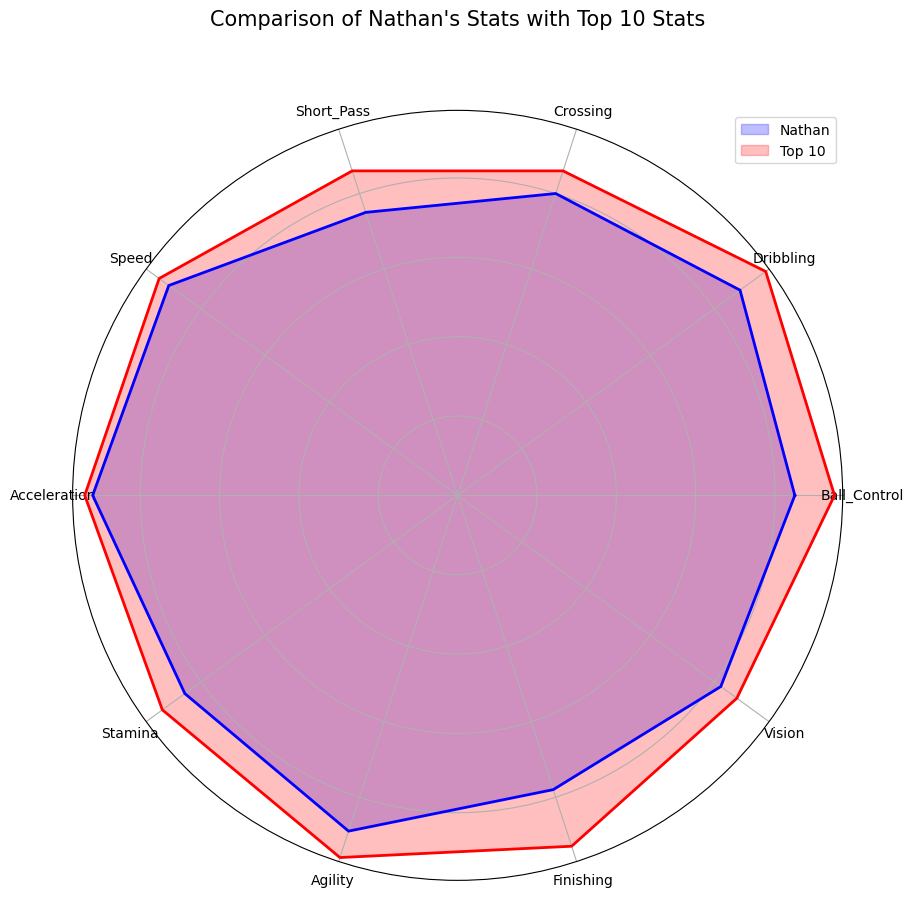

In [21]:
def radar_chart(stats, top_stats, attributes, title):
    
    labels = attributes
    n = len(labels)
    values = [stats[label] for label in labels]
    top_values = [top_stats[label] for label in labels]
    
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
    values += values[:1]
    top_values += top_values[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25, label='Nathan')
    ax.fill(angles, top_values, color='red', alpha=0.25, label='Top 10')
    ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid')
    ax.plot(angles, top_values, color='red', linewidth=2, linestyle='solid')
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='best')
    plt.show()

radar_chart(nathan_stats, max_values, attributes, 'Comparison of Nathan\'s Stats with Top 10 Stats')

fl.fig_caption("Comparison of Nathan's Stats with Top 10 Stats",
               "The illustration of a radar chart comparing Nathan's performance across attributes.")

The figures show the radar chart that compares Nathan's performance across various attributes with the top 10 values for each attribute. The chart provides a visual comparison of Nathan's stats against the best performances, highlighting areas of strength and potential improvement. Nathan’s performance is represented by the blue color and the top ten players are represented by the red color. It can be observed that Nathan’s performance is not far different from the ten used attributes. Based on the figure, acceleration, speed, stamina, vision, crossing and agility has the closest radar between Nathan’s performance and the top ten players of each attribute. Meanwhile short pass, dribbling, ball control, and finishing has an evident gap between them. With the six attributes of having a close radar between Nathan and the top ten players, it can be implied that Nathan has a well observed and performed skills and is reliable to its preferred left wing position. 

[ref]: #top
[Back to Table of Contents][ref]

<a name="res_dis"></a>
## Results and Discussions
In this section, we will present the findings from our data exploration and discuss their implications for football scouting and player analysis.
***

**Figure 1. Number of Left Wing Players per club**

    The resulting bar plot shows that each of the listed football clubs—SC Heerenveen, PSG, Bologna, Real Madrid, Manchester City, Cruz Azul, Milan, FC Barcelona, Valencia CF, Napoli, Olym. Lyonnais, Olym. Marseille, Liverpool, Angers SCO, Tondela, and Chelsea—has exactly one Left Wing (LW) player. The uniform length of the bars indicates an equal distribution of LW players across these clubs. This visualization effectively highlights that there is no club with more than one LW player among the clubs considered.

**Figure 2. Top Left Wing Players by Average Rating**

    The resulting bar plot illustrates the average ratings of the top Left Wing (LW) players. Cristiano Ronaldo leads with an average rating close to 99, followed by Neymar with an average rating around 95. Eden Hazard is next with a rating of 90, followed by Countinho at 85, Dimitri Payet at 84, and Lorenzo Insigne at 83. Julian Draxler and Nani both have ratings of 82, Deulofeu has a rating of 81, and Leroy Sané has a rating of 80. Further down, Memphis Depay has an average rating of 79, Sam Larsson and Ladislav Krejčí each have ratings of 77, Karl Toko-Ekambi is rated at 75, and both Jhon Murillo and Martín Rodríguez have ratings of 73. This plot provides a clear ranking of these players based on their average ratings, highlighting Cristiano Ronaldo and Neymar as the top performers among the LW players.

**Figure 3. Average Attribute of Left Wing Players**

    The bar plot displays the average values of key attributes for Left Wing (LW) players. The attributes are as follows: Ball Control with an average value of 83, Dribbling with 85, Crossing with 73, Short Pass with 76, Speed with 84, Acceleration with 86, Stamina with 76, Agility with 86, Finishing with 76, and Vision with 75. The plot reveals that Acceleration and Agility have the highest average values at 86, while Crossing and Vision have the lowest at 73 and 75, respectively. This visualization provides a clear comparative view of the overall performance metrics for LW players across various attributes.

**Figure 4. Top 10 Players by Each Attribute**

    The analysis of Left Wing (LW) players reveals significant insights into their performance across various attributes:

1.  **Ball Control**: Neymar leads with a Ball Control score of 94, closely followed by Cristiano Ronaldo at 92. Eden Hazard scores 90, and Dimitri Payet and Lorenzo Insigne both have scores of 89. Coutinho (87), Nani and Deulofeu (86), Julian Draxler (85), and Leroy Sané (83) also exhibit strong Ball Control. These results indicate that Neymar and Ronaldo possess superior ball handling abilities, essential for maintaining possession and executing complex maneuvers.

2. **Dribbling**: Neymar achieves a Dribbling score of 95, the highest among the players, showcasing his exceptional skill in maneuvering past opponents. Eden Hazard (93) and Cristiano Ronaldo (91) also exhibit strong dribbling capabilities. Payet and Deulofeu, with scores of 89, and Coutinho and Lorenzo Insigne, both at 88, further illustrate their effectiveness in dribbling. These figures underscore the top players' ability to create scoring opportunities through individual skill.

3. **Crossing**: Dimitri Payet leads in Crossing with a score of 86, followed by Cristiano Ronaldo with 84. Lorenzo Insigne and Nani both score 82, while Ladislav Krejčí scores 81. Eden Hazard's Crossing score is 80, and Julian Draxler has 78. Coutinho and Deulofeu, with scores of 77 and 76 respectively, and Neymar at 75, highlight varying proficiency in delivering accurate crosses. Payet’s leading score emphasizes his effectiveness in providing crucial attacking passes.

4. **Short Pass**: Dimitri Payet scores 86 in Short Pass, indicating his precision and vision in short-range passing. Coutinho follows with a score of 85, and Eden Hazard has 84. Cristiano Ronaldo and Julian Draxler both score 83, with Neymar, Lorenzo Insigne, and Nani at 81. Deulofeu and Ladislav Krejčí score 78 and 77, respectively. These results highlight Payet’s top performance in facilitating effective team play and build-up attacks.

5. **Speed**: Jhon Murillo achieves the highest Speed score of 93, demonstrating exceptional pace. Cristiano Ronaldo and Deulofeu both score 91, reflecting their ability to accelerate quickly. Leroy Sané scores 90, and Neymar and Martín Rodríguez each have 89. Memphis Depay scores 88, Eden Hazard at 86, and Lorenzo Insigne at 85. Ladislav Krejčí has a score of 83. Murillo’s top score indicates superior speed crucial for breaking through defenses.

6. **Acceleration**: Lorenzo Insigne leads with an Acceleration score of 93, followed by Neymar and Eden Hazard, both at 92. Leroy Sané scores 91, and Cristiano Ronaldo, Memphis Depay, and Jhon Murillo each have 90. Martín Rodríguez scores 89, with Coutinho and Deulofeu at 88. These results reveal Insigne’s outstanding quickness and burst of speed, essential for rapid attacking transitions.

7. **Stamina**: Cristiano Ronaldo leads with a Stamina score of 91, underscoring his ability to maintain high performance levels throughout a match. Leroy Sané scores 80, with Neymar and Coutinho both at 79. Memphis Depay and Sam Larsson score 78, while Eden Hazard, Lorenzo Insigne, and Ladislav Krejčí each score 77. Deulofeu scores 76, indicating that Ronaldo’s stamina is a significant asset in sustaining performance.

8. **Agility**: Neymar and Lorenzo Insigne both achieve the highest Agility score of 96, demonstrating their exceptional ability to quickly change direction. Deulofeu follows with a score of 93, and Eden Hazard, Nani, and Jhon Murillo each score 92. Coutinho scores 91, with Cristiano Ronaldo at 90 and Leroy Sané and Martín Rodríguez both at 88. These results reflect the top players' superior agility, allowing for effective evasion of defenders.

9. **Finishing**: Cristiano Ronaldo leads in Finishing with a score of 92, highlighting his proficiency in converting chances into goals. Neymar follows with a score of 89, and Eden Hazard scores 81. Dimitri Payet, Karl Toko-Ekambi, Julian Draxler, Nani, and Leroy Sané each score 77, with Deulofeu at 76 and Coutinho at 75. Ronaldo’s high score emphasizes his goal-scoring ability, a crucial attribute for forward players.

10. **Vision**: Coutinho and Dimitri Payet are tied at the top with Vision scores of 96, reflecting their exceptional ability to perceive and execute key passes. Eden Hazard scores 95, with Cristiano Ronaldo and Lorenzo Insigne both at 94. Neymar has a Vision score of 80, while Julian Draxler, Nani, and Memphis Depay each score 80. Sam Larsson and Deulofeu score 73. Coutinho and Payet’s high Vision scores highlight their playmaking skills and their capacity to create goal-scoring opportunities for teammates.


**Figure 5. Comparison of Nathan's Stats with Top 10 Stats**

    The radar chart highlights Nathan's performance relative to the top 10 players in various attributes. Nathan's strengths are most evident in **Acceleration** and **Speed**, where his performance, while not surpassing the top 10 values, is notably close. This indicates that Nathan performs exceptionally well in these areas, approaching the best possible scores. Conversely, Nathan's weaknesses are more pronounced in **Short Pass** and **Finishing**. The radar chart shows that the top 10 values for these attributes are significantly higher than Nathan's scores, suggesting considerable room for improvement. Overall, the chart reveals that Nathan's attributes in blue are consistently lower than the top 10 attributes in red, underscoring the competitive gap and areas where Nathan could enhance his performance to match or exceed top-level benchmarks.

[ref]: #top
[Back to Table of Contents][ref]

<a name="conc"></a>
## Conclusion and Recommendations
In this section, we will summarize our findings and provide recommendations based on the analysis performed.
***

Based on the data, Real Madrid is the most suitable club for Nathan. The club’s high-performance standards and competitive environment align well with Nathan’s strengths in Acceleration and Speed, which are crucial for Real Madrid's fast-paced playing style. Cristiano Ronaldo’s exemplary performance at Real Madrid, with top scores in Finishing and Stamina, highlights the club’s ability to enhance player skills and maintain high standards.

Nathan would benefit from Real Madrid’s top-tier training facilities and competitive atmosphere, which will help address his weaknesses in Short Pass and Finishing. The opportunity to develop alongside elite players like Ronaldo can significantly elevate Nathan’s game, making Real Madrid the ideal choice for his growth and success in elite football leagues.

[ref]: #top
[Back to Table of Contents][ref]

<a name="refe"></a>
## References
***

Agarwal, S. (2017, April 13). Complete FIFA 2017 Player dataset (Global). Kaggle. https://www.kaggle.com/datasets/artimous/complete-fifa-2017-player-dataset-global?resource=download

[ref]: #top
[Back to Table of Contents][ref]